In this notebook you'll find an example of how to generate a sinogram with the ASTRA toolbox and reconstruct it using various iterative reconstruction methods.

1. Investigate on noisy data how the number of iterations regularises the solution
2. Investigate what happens when subsampling in the angular direction; what kind of artifacts appear?
3. Investigate what happens when using a limited angular range; which features in the image are reconstructed well and which are not?
4. Is there a difference between various iterative methods?

> Hint: to make experimentation easier, write two functions; one that produces data for a given phantom (`u`) and settings (`nx`,`angles`,`sigma`) and one that performs a reconstruction for given noisy data (`f`) and settings (`niter`,`algo`).

In [ ]:
%pip install astra-toolbox

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom, binary_blobs
from skimage.draw import disk
import astra

In [ ]:
def getPhantom(nx, r = 0.9):
    """
    Define phantom image.

    input:
        nx - dimension of the input image
        r - radius of phantom, optional (default = 0.9)

    output:
        u - phantom image as 1d array of length nx*nx
    """
    # mask
    mask = np.zeros((nx,nx))
    ii,jj = disk((nx//2,nx//2),r * (nx//2))
    mask[ii,jj] = 1

    # binary blobs
    u = 0.5 * np.float64(binary_blobs(length=nx, blob_size_fraction=0.5))
    u += 0.5 * np.float64(binary_blobs(length=nx, blob_size_fraction=0.2))
    u *= mask

    # return
    return u

In [ ]:
# Generate data

## settings
nx = 128
na = 180
nd = int(1.5*nx)
angles = np.linspace(0,np.pi,na,False)
sigma = 1e1

## astra  projector
vol_geom = astra.create_vol_geom(nx,nx)
proj_geom = astra.create_proj_geom('parallel', 1.0, nd, angles)
proj_id = astra.create_projector('strip', proj_geom, vol_geom)

## get phantom, perform forward projection
u = getPhantom(nx)
f_id, f = astra.create_sino(u, proj_id)

## add noise
f_delta = f + sigma * np.random.randn(f.shape[0],f.shape[1])
f_delta_id = astra.data2d.create('-sino', proj_geom, data=f_delta)

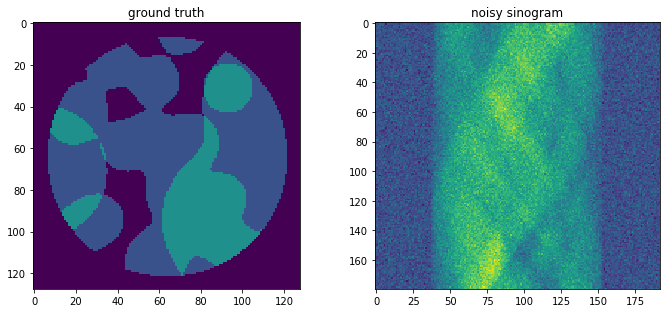

In [ ]:
# plot
fig,ax = plt.subplots(1,2)

ax[0].imshow(u,vmin=0,vmax=2)
ax[0].set_title('ground truth')

ax[1].imshow(f_delta)
ax[1].set_title('noisy sinogram')

fig.tight_layout()
fig.set_figwidth(10)

In [ ]:
# Reconstruction

## parameters
algo = 'SIRT' # Available algorithms: ART, SART, SIRT, CGLS
niter = 20

## Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

## Set up the parameters for a reconstruction algorithm
cfg = astra.astra_dict(algo)
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = f_delta_id
cfg['ProjectorId'] = proj_id

## Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

## run the algorithm
astra.algorithm.run(alg_id, niter)

## Get the result
u_rec = astra.data2d.get(rec_id)

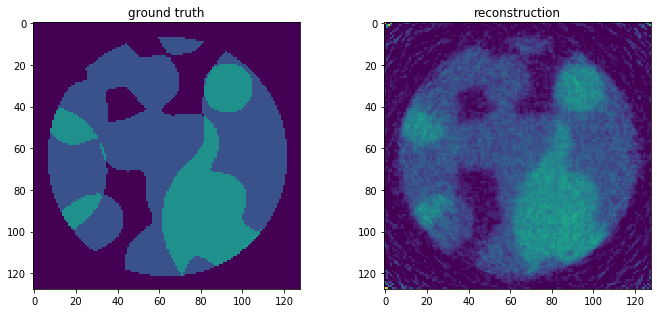

In [ ]:
# plot
fig,ax = plt.subplots(1,2)

ax[0].imshow(u,vmin=0,vmax=2)
ax[0].set_title('ground truth')

ax[1].imshow(u_rec,vmin=0,vmax=2)
ax[1].set_title('reconstruction')

fig.tight_layout()
fig.set_figwidth(10)

In [ ]:
# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(f_id)
astra.projector.delete(proj_id)